In [1]:
import numpy as np
import pandas as pd
from wesszumino import build_wz_hamiltonian
import pennylane as qml

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import os

In [2]:

def idx_to_bitlist(i: int, n: int):
    return [int(b) for b in format(int(i), f"0{n}b")]


def print_topk_basis_states(eigvec, num_qubits, k=20):
    probs = np.abs(eigvec) ** 2
    top = np.argsort(-probs)[:k]
    print(f"\nTop-{k} basis states by |psi|^2:")
    for rank, i in enumerate(top, start=1):
        bits = format(int(i), f"0{num_qubits}b")
        print(f"{rank:>2}. i={int(i):>5}  |{bits}>  prob={probs[i]:.6e}  amp={eigvec[i]}")


def choose_active_indices(eigvec, *, amp_thresh=1e-6, max_keep=None):
    """
    Choose active indices by amplitude threshold on |psi_i|.
    Optionally keep only the max_keep largest (by probability).
    """
    amps = np.abs(eigvec)
    active = np.where(amps > amp_thresh)[0]

    if max_keep is not None and len(active) > max_keep:
        probs = np.abs(eigvec) ** 2
        # keep largest max_keep among active
        active = active[np.argsort(-probs[active])[:max_keep]]

    return np.array(active, dtype=int)


def plot_full_heatmap_with_connectivity(
    H,
    active_indices,
    num_qubits,
    *,
    hij_thresh=1e-10,
    title="Hamiltonian heatmap (active connectivity)",
    show_basis_labels=True,
):
    """
    Plot full H heatmap and overlay red boxes ONLY where:
      i,j in active_indices and |H_ij| > hij_thresh
    Also labels active basis states on the right.
    """
    H_real = np.real(H)
    H_abs = np.abs(H)

    df = pd.DataFrame(H_real)

    plt.figure(figsize=(18, 15))
    ax = sns.heatmap(
        df,
        cmap="viridis",
        cbar=True,
        annot=False,
        linewidths=0.3,
        linecolor="gray",
        square=True,
    )

    active = np.array(active_indices, dtype=int)

    # overlay only "connected" active entries
    for i in active:
        for j in active:
            if H_abs[i, j] > hij_thresh:
                rect = patches.Rectangle((j, i), 1, 1, fill=False, edgecolor="red", linewidth=1)
                ax.add_patch(rect)

    if show_basis_labels:
        # add labels for active rows on the right
        for i in active:
            basis = format(int(i), f"0{num_qubits}b")
            ax.text(df.shape[1] + 0.2, i + 0.5, f"|{basis}⟩", va="center", ha="left", fontsize=8)

    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_active_submatrix_heatmap(
    H,
    active_indices,
    *,
    title="Active-subspace Hamiltonian",
):
    """
    Plot the active submatrix H[active, active].
    Much more readable than the full 2^n x 2^n plot.
    """
    active = np.array(active_indices, dtype=int)
    A = np.ix_(active, active)
    H_active = np.real(H[A])

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pd.DataFrame(H_active),
        cmap="viridis",
        cbar=True,
        annot=False,
        square=True,
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


cutoff: 8 N: 3 a: 1.0 potential: linear bc: dirichlet c: -0.8
num_qubits = 12  dim = 4096
Ground energy = 0.000000027357

Best computational basis seed (argmax |psi|^2):
  index i0 = 128
  bitstring = 000010000000  (as list: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
  prob = 8.989795e-01  amp = (0.9481453075835425+0j)

Top-20 basis states by |psi|^2:
 1. i=  128  |000010000000>  prob=8.989795e-01  amp=(0.9481453075835425+0j)
 2. i= 2048  |100000000000>  prob=4.540769e-02  amp=(-0.21309079521340213+0j)
 3. i=    8  |000000001000>  prob=4.540769e-02  amp=(-0.2130907952134016+0j)
 4. i=  160  |000010100000>  prob=4.587087e-03  amp=(-0.06772803653779033+0j)
 5. i=  385  |000110000001>  prob=2.293554e-03  amp=(0.0478910653286113+0j)
 6. i=  640  |001010000000>  prob=1.146777e-03  amp=(-0.03386410233378166+0j)
 7. i=  130  |000010000010>  prob=1.146777e-03  amp=(-0.033864102333781634+0j)
 8. i=   40  |000000101000>  prob=2.316949e-04  amp=(0.015221528861290919+0j)
 9. i= 2080  |100000100000>  p

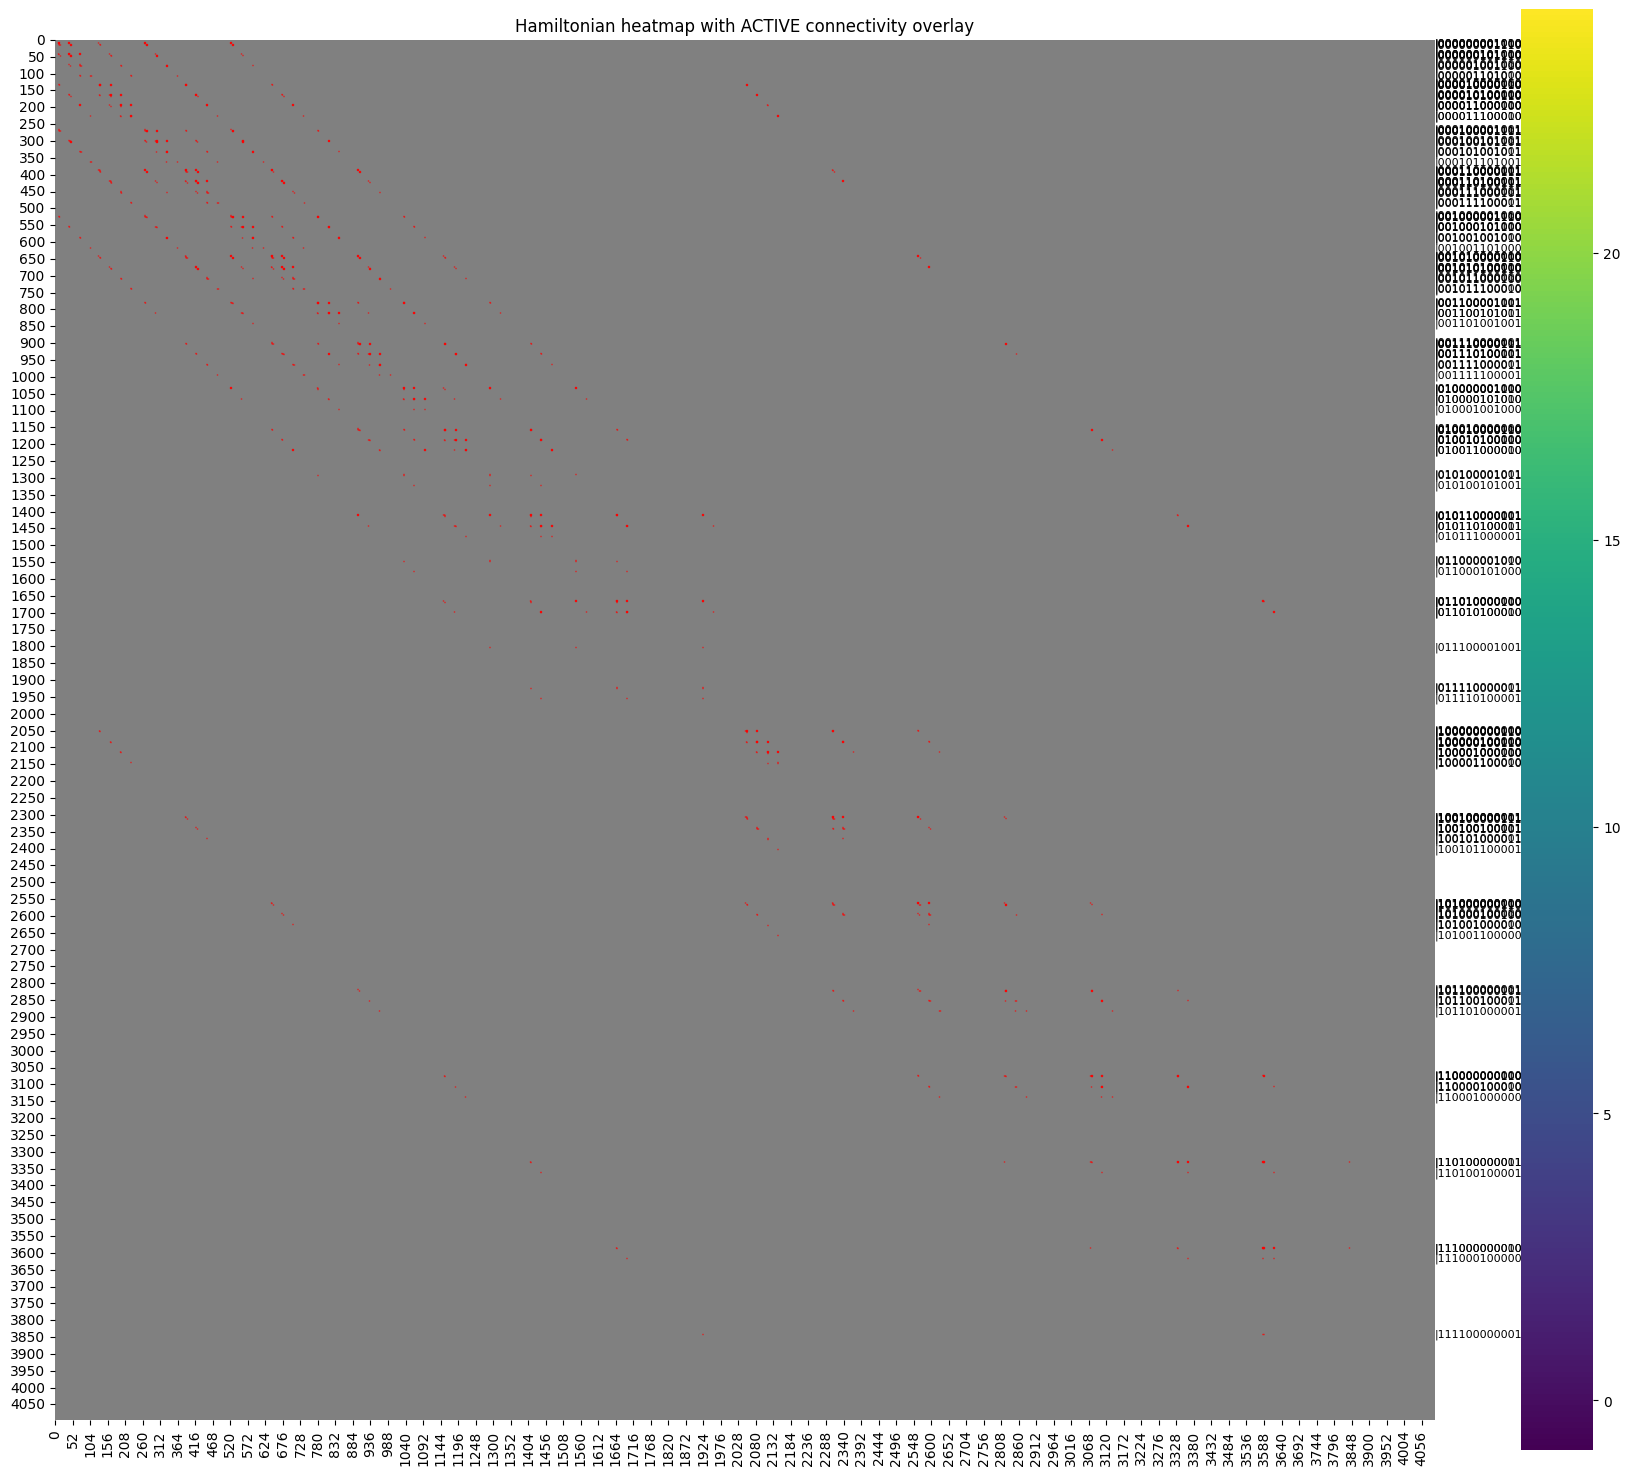

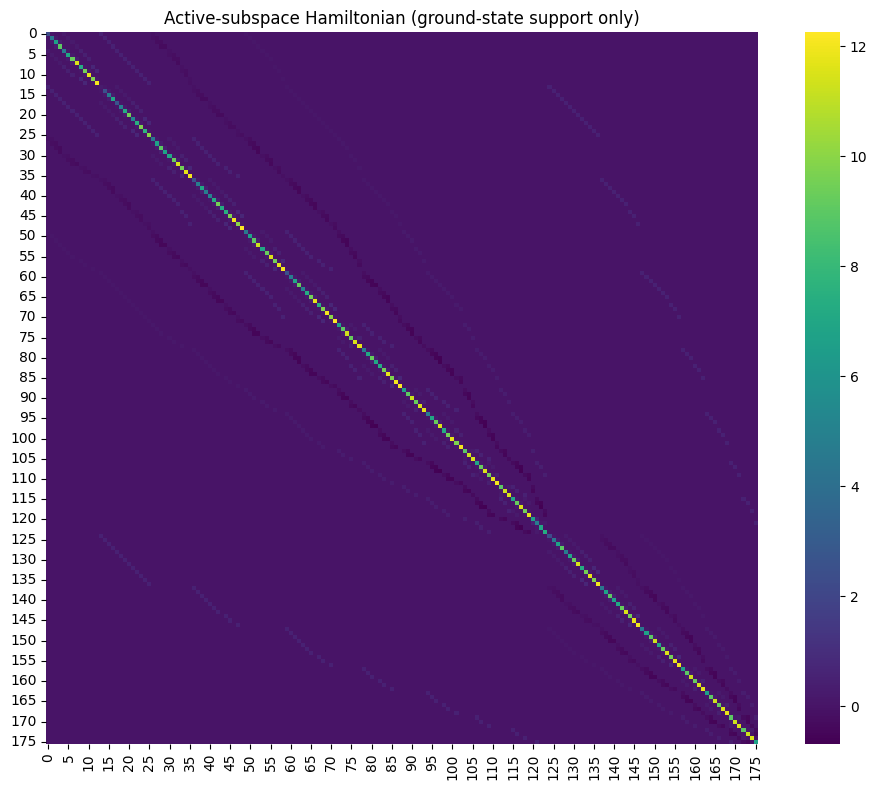

In [3]:
N = 3
a = 1.0
c = -0.8
potential = "linear"
boundary_condition = "dirichlet"

cutoffs = [8]

# thresholds you may tune
AMP_THRESH = 1e-6      # threshold on |psi_i| to call a basis state "active"
HIJ_THRESH = 1e-16     # threshold on |H_ij| to call a coupling "non-negligible"
TOPK = 20              # print top-k basis states

# If you want to avoid huge numbers of active states, cap them:
MAX_ACTIVE_KEEP = None  # e.g. 80


for cutoff in cutoffs:
    print("\n" + "=" * 80)
    print("cutoff:", cutoff, "N:", N, "a:", a, "potential:", potential, "bc:", boundary_condition, "c:", c)

    H_pauli, num_qubits = build_wz_hamiltonian(
        cutoff,
        N,
        a,
        c=c,
        m=1.0,
        potential=potential,
        boundary_condition=boundary_condition,
        remove_zero_terms=True,
    )

    # Dense matrix
    H = qml.matrix(H_pauli, wire_order=range(num_qubits))

    # Hermitian eigensolve (preferred)
    evals, evecs = np.linalg.eigh(H)
    min_index = int(np.argmin(evals))
    ground_e = float(np.real(evals[min_index]))
    ground_vec = np.asarray(evecs[:, min_index])

    print(f"num_qubits = {num_qubits}  dim = {H.shape[0]}")
    print(f"Ground energy = {ground_e:.12f}")

    # Choose a convenient basis state in the right sector: argmax |psi|^2
    probs = np.abs(ground_vec) ** 2
    i0 = int(np.argmax(probs))
    bs0 = idx_to_bitlist(i0, num_qubits)
    print(f"\nBest computational basis seed (argmax |psi|^2):")
    print(f"  index i0 = {i0}")
    print(f"  bitstring = {format(i0, f'0{num_qubits}b')}  (as list: {bs0})")
    print(f"  prob = {probs[i0]:.6e}  amp = {ground_vec[i0]}")

    # Print top-k basis states
    print_topk_basis_states(ground_vec, num_qubits, k=TOPK)

    # Active set by amplitude threshold (optionally cap by max_keep)
    active_indices = choose_active_indices(ground_vec, amp_thresh=AMP_THRESH, max_keep=MAX_ACTIVE_KEEP)
    print(f"\nActive basis states: {len(active_indices)} (|psi_i| > {AMP_THRESH})")

    # --- Plot 1: Full heatmap with *connectivity* overlay (can be heavy for large dim)
    plot_full_heatmap_with_connectivity(
        H,
        active_indices,
        num_qubits,
        hij_thresh=HIJ_THRESH,
        title="Hamiltonian heatmap with ACTIVE connectivity overlay",
        show_basis_labels=True,
    )

    # --- Plot 2: Active-subspace heatmap only (recommended)
    plot_active_submatrix_heatmap(
        H,
        active_indices,
        title="Active-subspace Hamiltonian (ground-state support only)",
    )


In [4]:
active = np.array(active_indices, dtype=int)
H_abs = np.abs(H)

# active submatrix
H_act = H_abs[np.ix_(active, active)]
np.fill_diagonal(H_act, 0.0)  # ignore diagonal

# pick a RELATIVE threshold (tune the 1e-10 / 1e-12)
HIJ_REL = 1e-10
HIJ_THRESH = HIJ_REL * H_act.max()

A = (H_act > HIJ_THRESH).astype(np.uint8)  # adjacency

# connected components via BFS
n = A.shape[0]
seen = np.zeros(n, dtype=bool)
comps = []

for s in range(n):
    if seen[s]:
        continue
    stack = [s]
    seen[s] = True
    comp = []
    while stack:
        u = stack.pop()
        comp.append(u)
        nbrs = np.where(A[u])[0]
        for v in nbrs:
            if not seen[v]:
                seen[v] = True
                stack.append(v)
    comps.append(comp)

print("HIJ_THRESH =", HIJ_THRESH)
print("num components:", len(comps))
print("component sizes:", sorted([len(c) for c in comps], reverse=True))

# if you want the actual basis labels per component:
for k, comp in enumerate(sorted(comps, key=len, reverse=True)):
    print(f"\nComponent {k} size {len(comp)}:")
    for u in comp[:20]:  # show first 20
        idx = int(active[u])  # original basis index in full Hilbert space
        print(idx, format(idx, f"0{num_qubits}b"))


HIJ_THRESH = 6.846531968814576e-11
num components: 1
component sizes: [176]

Component 0 size 176:
8 000000001000
520 001000001000
1032 010000001000
1544 011000001000
1801 011100001001
1921 011110000001
3841 111100000001
3586 111000000010
3331 110100000011
3076 110000000100
2821 101100000101
2566 101000000110
2311 100100000111
391 000110000111
903 001110000111
1158 010010000110
1413 010110000101
1668 011010000100
423 000110100111
678 001010100110


In [5]:
vals = H_act[H_act > 0].ravel()
print("offdiag count:", vals.size)
print("max:", vals.max())
print("median:", np.median(vals))
print("min (nonzero):", vals.min())


offdiag count: 1524
max: 0.6846531968814575
median: 0.24999999999999986
min (nonzero): 3.469446951953614e-18


In [6]:
# active_indices: your 48 full-space indices
# num_qubits: e.g. 9
active = np.array(active_indices, dtype=int)

# Bit-matrix: shape (n_active, num_qubits), bits[0] is MSB (same as format(..., '0nb'))
bits = np.array([[int(b) for b in format(int(i), f"0{num_qubits}b")] for i in active], dtype=int)

print("num_active =", bits.shape[0], "num_qubits =", bits.shape[1])

# 1) Fixed qubits
col_sums = bits.sum(axis=0)
fixed0 = np.where(col_sums == 0)[0]
fixed1 = np.where(col_sums == bits.shape[0])[0]

print("\nFixed to 0 qubits (index in bitstring):", fixed0.tolist())
print("Fixed to 1 qubits (index in bitstring):", fixed1.tolist())

# 2) Hamming weight distribution (often tracks number sectors)
weights = bits.sum(axis=1)
print("\nHamming weight counts:", dict(Counter(weights)))

# 3) Pairwise parity checks for a quick “sector fingerprint”
# (useful if you suspect a conserved Z2 symmetry on some subset)
def parity_eigs(subset):
    # eigenvalue of Π Z on subset for a computational basis state:
    # +1 if even number of 1s on subset, -1 if odd
    ones = bits[:, subset].sum(axis=1)
    return np.where(ones % 2 == 0, 1, -1)

# Example: check parity on all qubits (edit subsets as you like)
all_par = parity_eigs(list(range(num_qubits)))
print("\nParity over ALL qubits (+1 even, -1 odd):", dict(Counter(all_par)))


num_active = 176 num_qubits = 12

Fixed to 0 qubits (index in bitstring): [7]
Fixed to 1 qubits (index in bitstring): []

Hamming weight counts: {np.int64(1): 3, np.int64(2): 18, np.int64(3): 48, np.int64(4): 53, np.int64(5): 42, np.int64(6): 12}

Parity over ALL qubits (+1 even, -1 odd): {np.int64(-1): 93, np.int64(1): 83}


In [25]:
probs = np.abs(ground_vec)**2
i0 = int(np.argmax(probs))
seed_bits = [int(b) for b in format(i0, f"0{num_qubits}b")]
print("Seed index:", i0, "bitstring:", seed_bits, "prob:", probs[i0])


Seed index: 32 bitstring: [0, 0, 0, 1, 0, 0, 0, 0, 0] prob: 0.8990453995221824


In [7]:
import numpy as np
import itertools
from collections import Counter

active = np.array(active_indices, dtype=int)
bits = np.array([[int(b) for b in format(int(i), f"0{num_qubits}b")] for i in active], dtype=int)

def z_parity_eigs(subset):
    ones = bits[:, subset].sum(axis=1)
    return np.where(ones % 2 == 0, 1, -1)

def find_constant_z_parities(max_size=4):
    found = []
    for r in range(1, max_size + 1):
        for subset in itertools.combinations(range(num_qubits), r):
            eigs = z_parity_eigs(list(subset))
            if np.all(eigs == eigs[0]):
                found.append((subset, int(eigs[0])))
    return found

const_parities = find_constant_z_parities(max_size=4)
print("Constant Z-parities (subset -> eigenvalue):")
for subset, eig in const_parities:
    print(subset, eig)


Constant Z-parities (subset -> eigenvalue):
(7,) 1
(3, 11) 1
(0, 4, 8) -1
(3, 7, 11) 1
(0, 4, 7, 8) -1


In [8]:
num_qubits = 9  # for N=3, cutoff=4
basis_state = [0,0,0,1,0,0,0,0,0]

ops = [
    ("SingleExcitation", -0.4317178464550532, [0,3]),
    ("SingleExcitation",  0.44214318791385004, [3,6]),
    ("RY",               -0.14048970190131835, [4]),
    ("RY",               -0.07840635488548905, [1]),
    ("RY",               -0.07840635244716604, [7]),
]

name_to_gate = {
    "RY": qml.RY,
    "RZ": qml.RZ,
    "RX": qml.RX,
    "SingleExcitation": qml.SingleExcitation,
}

dev = qml.device("default.qubit", wires=num_qubits, shots=None)

@qml.qnode(dev)
def state_circuit():
    qml.BasisState(np.array(basis_state, dtype=int), wires=range(num_qubits))
    for name, theta, wires in ops:
        name_to_gate[name](theta, wires=wires)
    return qml.state()

psi_ans = state_circuit()

# Exact ground state from your diagonalization (make sure it's normalized)
psi0 = ground_vec / np.linalg.norm(ground_vec)

# Energy
H_dense = qml.matrix(H_pauli, wire_order=range(num_qubits))
E = np.vdot(psi_ans, H_dense @ psi_ans).real

# Fidelity with exact ground state
F = abs(np.vdot(psi0, psi_ans))**2

def z_parity(bitstring, wires):
    ones = sum(bitstring[w] for w in wires)
    return 1 if ones % 2 == 0 else -1

# sector checks in computational basis for the seed (not the final superposition)
print("Seed constraints:",
      "Z5 =", z_parity(basis_state,[5]),
      "Z0Z3Z6 =", z_parity(basis_state,[0,3,6]),
      "Z2Z8 =", z_parity(basis_state,[2,8]))

print("Exact energy of found ansatz =", E)
print("Fidelity with exact ground state =", F)


TransformError: Wires in circuit [3, 7, 6, 5, 2, 1, 0, 4, 10, 11, 9, 8] are inconsistent with those in wire_order [0, 1, 2, 3, 4, 5, 6, 7, 8]